# Pre Simulation Testing

Now that we have created our input file we need to verify that our simulation parameters will give a good simulation.

The YAML input file can be found at [input_file](https://raw.githubusercontent.com/murillo-group/sarkas/master/docs/documentation/Tutorial_NB/input_files/yukawa_mks_p3m.yaml) and this notebook at [notebook](https://raw.githubusercontent.com/murillo-group/sarkas/master/docs/documentation/Tutorial_NB/Pre_Simulation_Testing.ipynb)



In [1]:
# Import the usual libraries
%pylab
%matplotlib inline
import os

# Choose the plot style MSUstyle or PUBstyle
plt.style.use('PUBstyle')

# Import sarkas
from sarkas.processes import Simulation, PostProcess, PreProcess

# Create the file path to the YAML input file
input_file_name = os.path.join('input_files', 'yukawa_mks_p3m.yaml')

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Simulation Parameters

Let's verify our input parameters

In [2]:
preproc = PreProcess(input_file_name)
preproc.setup(read_yaml=True)










 _______  _______  _______  _        _______  _______ 
(  ____ \(  ___  )(  ____ )| \    /\(  ___  )(  ____ \
| (    \/| (   ) || (    )||  \  / /| (   ) || (    \/
| (_____ | (___) || (____)||  (_/ / | (___) || (_____ 
(_____  )|  ___  ||     __)|   _ (  |  ___  |(_____  )
      ) || (   ) || (\ (   |  ( \ \ | (   ) |      ) |
/\____) || )   ( || ) \ \__|  /  \ \| )   ( |/\____) |
\_______)|/     \||/   \__/|_/    \/|/     \|\_______)
                                                      


An open-source pure-python molecular dynamics suite for non-ideal plasmas.



* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
                                 Preprocessing                                  
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *

Job ID:  yocp
Job directory:  Simulations/yocp_pppm

Equilibration dumps directory: 
 Simulations/yocp_pppm/PreProcessing/Equilibratio

As you can see the output is rather verbose, so let's unpack it.

### Sarkas Figlet
The first screen output is the Sarkas Figlet. This is printed at the beginning of every process by the static method `screen_figlet()` of the `InputOutput` class. The Figlet font and colors are chosen randomly from a predefined set in `sarkas.utilities.io`. This function assumes a white background if you are running a Jupyter notebook, while a dark background in the case of an IPython/Python kernel.

### Storage
Next Sarkas prints the path where the snapshots (`dumps`) and the thermodynamics information of the simulation will be stored. Notice that these are in a directory called `Simulations/yocp_ppm/PreProcessing`. The actual simulation's dumps and energy files will be in a different directory, see next [page](https://murillo-group.github.io/sarkas/documentation/Tutorial_NB/Simulation_Docs.html). 

### PARTICLES
In this section we can find info about the particles we are simulating. Importantly we find the physical constants like the plasma frequency and Debye length.

### SIMULATION BOX
Next we have info on the simulation box with relevant lengths and parameters. These include the value of the Wigner-Seitz radius, ``a_ws``, the number of non zero dimensions, and the length of the simulation box sides in terms of ``a_ws`` and its numerical value in the chosen units. 

### ELECTRON PROPERTIES
This section prints thermodynamics quantities as well as dimensionless parameters of the surrounding electron liquid. Here we find the Thomas-Fermi length which is used for the screening parameter $\kappa$ of our Yukawa potential. Formulas for the calculation of each of these quantities can be found in the Electron Properties [page](https://murillo-group.github.io/sarkas/theory/electron_properties.html#) in the Theoretical Background section.

### POTENTIAL
This section prints potential specific parameters. In the case of Yukawa we find the electron temperature used for the calculation of $\lambda_{\rm TF}$ and $\kappa = a_{ws}/\lambda_{\rm TF}$. 
The last line prints the coupling parameter as defined [here](https://murillo-group.github.io/sarkas/theory/coupling_constant.html)

### ALGORITHM
This section prints information about the choice of our algorithm. Sarkas uses a generalized P3M (or PPPM) algortihm to handle medium to long range interactions. More info can be found in our page on [PPPM](../theory/PPPM.html) and DSGM17 in [Referemces](../theory/references.html). 

There are two parts in this algorithm: particle-particle (PP) and particle-mesh (PM). The former consists of a Linked-Cell-List (LCL). The PM instead consists in depositing the charges on a mesh, move to Fourier space, solve Poisson equation on the mesh and get the electric field, inverse Fourier to return to real space, and finally use the Electric field to push the particles. 

As such this algorithm requires nine parameters: the charge assignment order ``Potential.pppm_cao``, the number of aliases of the Fast Fourier Transform (FFT) per direction, ``Potential.pppm_aliases``, the Ewald screening parameter `Potential.pppm_alpha_ewald`, the number of mesh points per direction ``Potential.pppm_mesh``, and the short-range cut-off `Potential.rc`. 

Beside the choice of parameters Sarkas outputs the most relevant information for this algorithm: the number of cells per dimension for the LCL algorithm, the number of particles in the LCL loops, number of neighbors per particle, and the error in the force calculation. This is the error due to our choice of parameters. For more details on the way this is calculated see the page [Force Error](../theory/force_error.html). This number is dimensionless since all the variable have been rescaled. 
There is no _good_ value for the Force error and it is up to YOU to decide. In Non-Ideal plasmas it is usually chosen to be less than ``1e-5``. In this case we have `Tot Force Error = 6.442673e-06`. 

Below we show how to choose all the above parameters to minimize the force error.

### THERMOSTAT
Next we find information about the thermostat used. At the moment Sarkas supports the Berendsen thermostat only. You can learn more about it on this [page](https://murillo-group.github.io/sarkas/theory/thermostats.html#berendsen-thermostat). 
The parameter `relaxation_timestep` tells us the timestep number at which the thermostat will be turned on. Before then the system will evolve at constant energy. A good number for this is the timestep equivalent to 1 or 2 plasma periods as this allows the system to convert most of its potential energy into kinetic energy and thus reaching its maximum value. Turning on the thermostat once the kinetic energy is maximal is the most efficient way to thermalize.

Note that there is a Warning message. This is because we did not define the equilibration `temperatures` (or `temperatures_eV`) in the `Thermostat` section of the YAML file. As the warning says, this is not a problem as Sarkas will use the temperatures defined in the `Particles` section. 

### INTEGRATOR
The last section prints out info about our choice of Integrator and about the timing of the phases of our simulation. The most important parameters here are the `Total plasma frequency` and `w_p dt`. The total plasma frequency is calculated from 

$$ \omega_{\rm tot} = \left [ \sum_i \omega_i^2 \right ]^{1/2} $$

where $\omega_i$ is the plasma frequency of species $i$. In the case of a one component plasma, as in this case, the total plasma frequency is the same as the plasma frequency printed in the `PARTICLES` section above.
The number `w_p dt` tells us the fraction of plasma periods that corresponds to our choice of `dt`. A non-written rule among researchers says that we should choose a `dt` such that $\omega_p dt < 1/ 25$.

### Initialization Times
In this section are indicated the times for the initialization part of the simulation. These times are

- `Potential Initialization` where the all the potential parameters, including the Optimal Green's function in the case of PPPM algorithm, are calculated.
- `Particles Initialization` where the particles positions and velocities are initialized. This includes the case where a specific particles distribution is chosen.

Al of the above output is intended to be a check on the choice of parameters. The real advantage of using `PreProcess` comes next.

## Parameter Optimization

Plasmas main characteristic is the long range Coulomb interaction between particles. Sarkas uses the generalized PPPM algortihm which requires several parameters. The most important ones are: the short-range cut-off ($r_c$), the Ewald parameter ($\alpha$), the number of mesh points per direction.

The `PreProcess` class has two primary roles: help in the decision of the above parameters and provide an estimate time of the various phases of a simulation. 

Let's run the following code.



========================== Times Estimates =========================== 

Optimal Green's Function Time: 
0 min 3 sec 937 msec 11 usec 81 nsec 

Time of PP acceleration calculation averaged over 20 steps: 
0 min 0 sec 148 msec 748 usec 259 nsec 

Time of PM acceleration calculation averaged over 20 steps: 
0 min 0 sec 55 msec 969 usec 597 nsec 


Running 21 equilibration and production steps to estimate simulation times



  0%|          | 0/21 [00:00<?, ?it/s]

Time of a single equilibration step averaged over 20 steps: 
0 min 0 sec 232 msec 938 usec 318 nsec 



  0%|          | 0/21 [00:00<?, ?it/s]

Time of a single production step averaged over 20 steps: 
0 min 0 sec 218 msec 994 usec 288 nsec 



----------------------- Total Estimated Times ------------------------ 


Equilibration Time: 0 hrs 19 min 24 sec

Production Time: 0 hrs 18 min 14 sec

Total Run Time: 0 hrs 37 min 39 sec


========================= Filesize Estimates ========================= 


Equilibration:

Checkpoint filesize: 0 GB 1 MB 501 KB 106 bytes
Checkpoint folder size: 0 GB 744 MB 695 KB 776 bytes

Production:

Checkpoint filesize: 0 GB 1 MB 501 KB 106 bytes
Checkpoint folder size: 0 GB 744 MB 695 KB 776 bytes

Total minimum needed space: 1 GB 465 MB 367 KB 528 bytes


============================ Timing Study ============================ 



Mesh = 8 x 8 x 8 : 
alpha = 0.0691 / a_ws = 6.0727e+09 
PM Err = 3.803346e-13
Optimal Green's Function Time: 
0 min 0 sec 10 msec 303 usec 594 nsec 



Mesh = 10 x 10 x 10 : 
alpha = 0.0864 / a_ws = 7.5909e+09 
PM Err = 8.496793e-11
Optimal Green's Function Time: 
0 

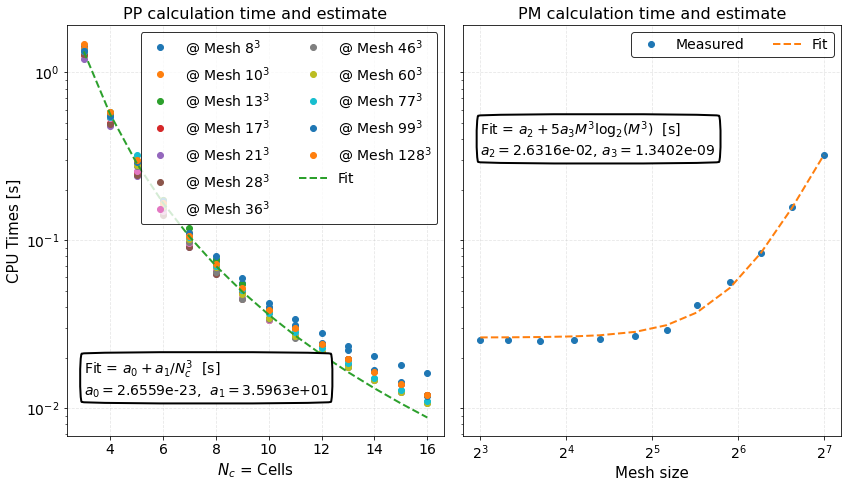

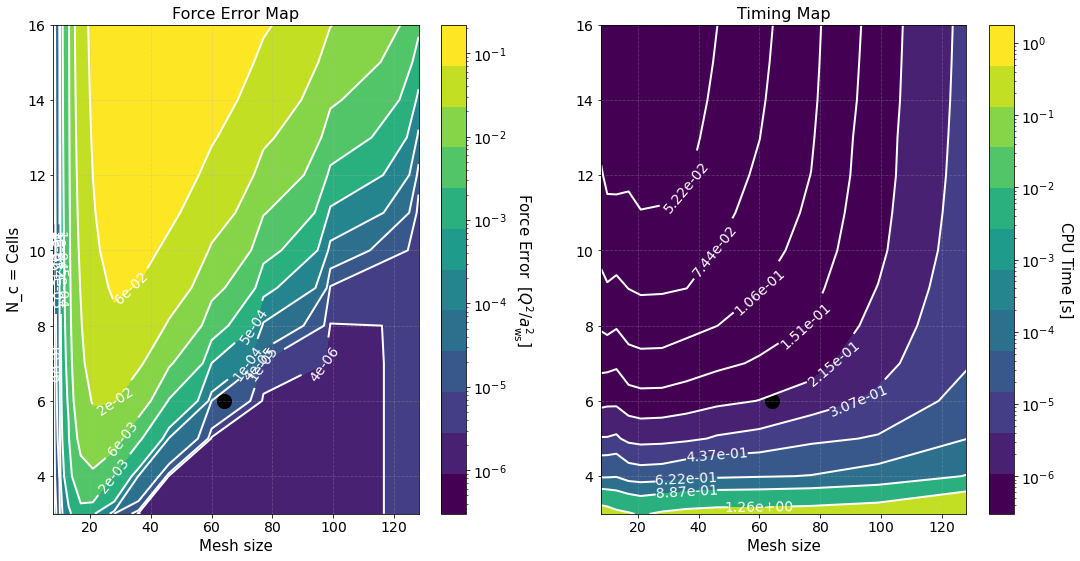

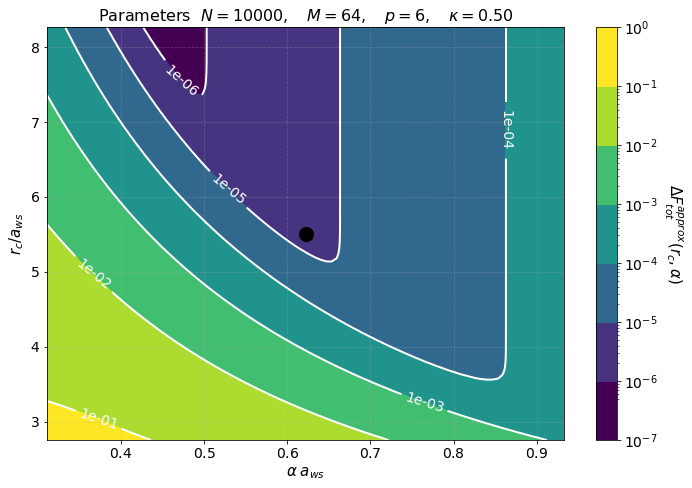

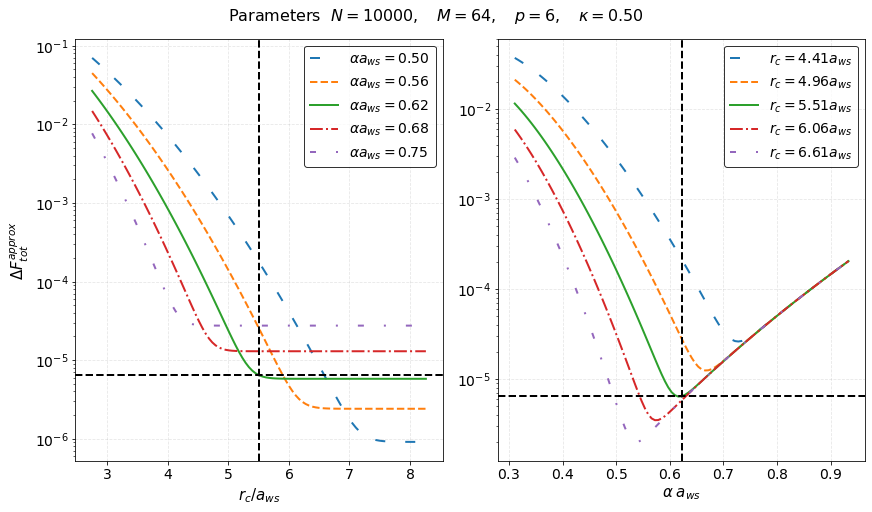

In [3]:
preproc.run(
    timing=True, # time estimation, default is True
    loops = 20,   # the number of timesteps to average, Default is 10
    pppm_estimate=True,   # Default is False
    timing_study = True,  # Default is False
    remove = True, # Save some space. Default is False
           )
# Note that the argument `loops` should be chosen to be larger than `production_dump_step`
# in order to get a more accurate estimate. 

Another long output. Let's unpack it

### Times Estimate
It shows the times needed for the force calculation and the averaged time for an equilibration and production time step. 

As you can see the calculation of the optimal Green's function takes a relatively long time. Fortunately this needs be calculated once at the beginning of the simulation. We note also that the PM part takes ~3x the time it takes for the PP part. This is specific to this hardware and the opposite case could be true on other machines.

Next Sarkas will run `loops` timesteps for each phase to estimate the time of each. These are indicated by the
green bars, a nice feature from the ``tqdm`` package. Note that this does not show up on the webpage, but it will in your notebook. Note also that the actual number of loops displayed is 21 instead of 20. The first timestep takes longer than the others because this is the first time that Numba is called. Therefore in order to avoid a skewed mean Sarkas runs one more timestep. 

Below the green bars we find the average time of each phase. The equilibration phase takes longer than the production phase due to the presence of a thermostat.

At the end all the estimates are put together to calculate the equilibration, production, and total run times.

The Equilibration and Production times are then calculated by multiplying the above times by `equilibration_steps` and `production_steps`, respectively. 

>**_NOTE:_**  These times will vary depending on the computer hardware. For this tutorial we used a 2019 Dell XPS 8930 with Intel Core i7-8700K @ 3.70Ghz and 48GB of RAM running Ubuntu 18.04.

### Filesize Estimate
Next Sarkas will estimate the size of the simulation. It calculates the size of an equilibration and a production dump file and multiplies it by the total number of dumps. The option `remove = True` will remove the dump files produced by `preproc.run()` in order to save up space. 

This simulation should take about ~800 MB of space.

These first two sections are produced by the first two options `timing = True` and `loops = 20`.

### Timing Study
The option `timing_study = True` is used to calculate the force error and estimate its calculation time for several mesh sizes and LCL cells. The array of mesh sizes can be changed by setting `preproc.pm_meshes` to the desired array before the command `run()`. For each mesh size Sarkas sets `pppm_alpha_ewald = 0.3 * m / parameters.box_lengths.min()`, calculates `pp_cells` as given by

        max_cells = int(0.5 * parameters.box_lengths.min() / parameters.a_ws)
        pp_cells = np.arange(3, max_cells, dtype=int)

prints out the calculation of time of the optimized green function, and produces the first two figures. 

The first figure shows plots of the computation times of the PP and PM parts with their respective fits. The PP and PM part are fitted independently in order to show the correct scaling of each algorithm and to better identify the most time expensive between the two. 

The second figure shows color maps of the total computation time (left) and the total force error (right) $\Delta F_{\rm tot}$, see [Force Error](../theory/force_error.html)

$$ \Delta F_{\textrm{tot}} = \sqrt{ \Delta F_{\mathcal R}^2 + \Delta F_{\mathcal F}^2 }, $$

where $\Delta F_{\rm PP(PM)}$ is the force error of the PP (PM) part.
These maps are created using `matplotlib.pyplot.contourf()` method by passing the data points in the first figure and not the fits, hence, the staggered contour lines. The fits are provided as a way for you to calculate the computation time for meshes and cells different than those computed.

As expected the maps indicate that the smaller the force error the larger the computation time. They are meant to provide an overview of the parameter space and help you decide the optimal value for $M$ and $N_c$. 

### Force Error
The Ewald parameter and cut off radius are chosen with the option `pppm_estimate = True`. This option produces the last two figures shown above. 

The first figure is a contour map in the $(r_c,\alpha)$ parameters space of 

$$ \Delta F_{\textrm{tot}}^{(\textrm{approx})}( r_c, \alpha) = \sqrt{ \Delta F_{\rm PP}^2 +
            ( \Delta F_{\rm PM}^{(\textrm{approx})} ) ^2 }. $$
            
$\Delta F_{\rm PM}^{(\textrm{approx})}$ is calculated from an approximation of the PM force error, hence the superscript $\rm approx$, and its functional form is different than the one calculated in $\Delta F_{\rm PM}$. See [Force Error](../theory/force_error.rst) for more detail. The numbers on the white contours indicate the value of $\Delta F_{\textrm{tot}}^{(\textrm{apprx})}$ along those lines and the black dot indicates our choice of parameters. Notice that our parameter choice falls in the region in between ``1e-5`` and ``1e-6`` as expected, recall `Tot Force Error = 6.442673e-06`. This plot tells us that if we want a force error of the order 1e-6 we need to choose values that fall into the small purple triangle at the top.

However, our choice of parameters while being good, it might not be optimal. In order to find the best choice we look at the second figure.

The left panel is a plot of $\Delta F_{\textrm{tot}}^{(\textrm{approx})}$ vs $r_c/a_{\rm ws}$ at
five different values of $\alpha a_{\rm ws}$ while the right panel is a plot of
$\Delta F_{\textrm{tot}}^{(\textrm{approx})}$ vs $\alpha a_{\rm ws}$ at five different values of $r_c/a_{\rm ws}$. The vertical black dashed lines indicate our choice of $\alpha a_{\rm ws}$ and $r_c/a_{\rm ws}$. The horizontal black dashed lines, instead, indicate the value `Tot Force Error = 6.442673e-06`.

These plots show that our analytical approximation is a very good approximation and that our choice of parameters is optimal as the intersection of the dashed lines falls exactly in the minimum of the curves. From the left panel we find that larger values for $r_c = 5.51$ lead to an inefficient code since we will be calculating the interaction for many more particles without actually reducing the force error. Similarly, the right panel shows that our choice of $r_c$ is close to optimal given $\alpha a_{ws} = 0.614$.

Some good rules of thumb to keep in mind while choosing the parameters are

- larger (smaller) $\alpha$ lead to a smaller (larger) PM error, but to a larger (smaller) PP error,
- larger (smaller) $r_c$ lead to a smaller (greater) PP part but do not affect the PM error,
- keep an eye on the PM and PP calculation times.
- larger $r_c$ lead to a longer time spent in calculating the PP part of the force since there are more neighbors,
- larger or smaller $\alpha$ do not affect the PM calculation time since this depends on the number of mesh points,
- choose the number of mesh points to be a power of 2 since FFT algorithms are most efficient in this case.

>**_NOTE:_**  The above investigation is useful in choosing the parameters $r_c$ and $\alpha$ for fixed values of the charge approximation order, $p$, the number of mesh points, $M_x = M_y = M_z$, and number of aliases $m_x = m_y = m_z$.


## Post Processing

All the above information are needed in order to run a simulation and produce data to be analyzed in the post-processing phase. However, the optimal choice of the above parameters does not necessarily indicate that our desired physical observable is calculated correctly. Thus, we need to verify that our choices lead to the desired physical result.

By setting `postprocessing=True` as the argument of `run()` we will print the parameters of the physical observables that we decided to calculate in the `PostProcessing` section of the YAML file. 

In [4]:
preproc.run(timing=False, # So that we don't redo what we did already
            postprocessing=True)




* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
                                 Preprocessing                                  
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *


==================== Radial Distribution Function ==================== 

Data saved in: 
 Simulations/yocp_pppm/PostProcessing/RadialDistributionFunction/Production/RadialDistributionFunction_yocp.csv
Data accessible at: self.ra_values, self.dataframe

No. bins = 500
dr = 0.0110 a_ws = 1.2540e-13 [m]
Maximum Distance (i.e. potential.rc)= 5.5100 a_ws = 6.2702e-11 [m]


===================== Static Structure Function ====================== 

k wavevector information saved in: 
 Simulations/yocp_pppm/PostProcessing/k_space_data/k_arrays.npz
n(k,t) Data saved in: 
 Simulations/yocp_pppm/PostProcessing/k_space_data/nkt.h5
Data saved in: 
 Simulations/yocp_pppm/PostProcessing/StaticStructureFunction/Production/

### Radial Distribution Function

The most common physical observable is the Radial Distribution Function (RDF). Our choice of `Parameters.rdf_nbins : 500` and `Potential.rc : 6.2702e-11` leads to `dr = 0.0110 a_ws` and `r_max = 5.5100 a_ws`. If we desire to have a larger `r_max` we will need to increase `potential.rc`. As mentioned above this might lead to an inefficient force calculation, but the force error plots can help us find an optimal `alpha` for a larger `rcut`

### Static Structure Factor

The Fourier transform of the RDF leads to the Static Structure Factor (SSF). The important parameters for the SSF is the desired range of wavevectors to calculate. The output shows the chosen number of harmonics of the smallest wavevector in each of cartesian directions. These are the same values in the YAML file. 

Next, we find the total number of $\mathbf k$ (vectors) that will be calculated. This number corresponds to the total number of combinations of the three harmonics directions, `n_x * n_y * n_z - 1` .

The smallest $\mathbf k$ vector that can be fitted int the simulation box is given by the length of the longest side of the simulation box, $L$. This is computed from the total number of particles, $N$.

$$ k_{\rm min} = \frac{2\pi}{L} \approx \frac{3.9}{N^{1/3}}$$

In this case, $k_{\rm min} a_{\rm ws} = 0.1809 $, if we need to investigate smaller wavevectors we need to increase the number of particles. The above equation can be used to find the value of $N$ for the desired $k_{\rm min}$ value.

The largest wavevector, instead, is defined by our choice of `angle_averaging`. This parameter can take three values `principal_axis`, `custom`, `full`. The default value for this parameter is `principal_axis`. More about this parameter will be explained in the [Post Processing notebook](https://murillo-group.github.io/sarkas/documentation/Tutorial_NB/Post_Processing_Docs.html). For the moment we mention that in the case of `angle_averaging = principal_axis` the maximum value is calculated as

$$ k_{\rm max} = \frac{2 \pi}{L} \sqrt{3} n_x, $$

while in the case `angle_averaging = full` as

$$ k_{\rm max} = \frac{2 \pi}{L} \sqrt{n_x^2 + n_y^2 + n_z^2}. $$

### Dynamic Structure Factor and Current Correlation Function

These two functions depend on the same parameters. However, it can be the case that only one of the two is calculated, hence, a section for each of them. The parameters are divided in two sections, frequency and wavevector constants. The wavevectors constants are the same as those in SSF. This is due to the fact that the $\mathbf k$ data is saved once computed the first time. Any subsequent calculation requiring this data will read in the saved data and not recompute it. Therefore it is important to check that the parameters in the YAML file are the same. 

As per the frequency constants, the first parameters is the number of slices. This indicates the number in which to divide the timeseries data. A DSF (or CCF) will be calculated for each slice and the final result will be an average over all the slices. The important parameters are then the frequency step and the maximum frequency calculated from the FFT. For each of these values, the corresponding equation is given so to help the user decide the correct parameters.
The maximum frequency is given by 
 
$$ \omega_{\rm max} = \frac{\pi}{d_s \Delta t } $$

where $\Delta t$ is the timestep and $d_s$ the snapshot interval (`prod_dump_step`). The frequency step instead is 

$$ \Delta \omega = 2\pi \frac{d_s N_s}{M_T \Delta t} $$

where $N_s$ is the number of slices (`no_slices`), $M_T$ the number of timesteps (`production_steps`).